<a href="https://colab.research.google.com/github/altaga/Facemask-Detector-ZCU104/blob/main/Benchmarks%20Notebooks/RPi%20-%20Train%20and%20Test/Train/RPi_Train_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Press the button above this box to open the notebook directly in Google Colab.

## Tf Lite Model Train


# Load the libraries


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import tensorflow.keras
from tensorflow.keras.layers import Dense, Conv2D, InputLayer, Flatten, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import distutils
if distutils.version.LooseVersion(tf.__version__) <= '2.0':
    raise Exception('This notebook is compatible with TensorFlow 1.14 or higher, for TensorFlow 1.13 or lower please use the previous version at https://github.com/tensorflow/tpu/blob/r1.13/tools/colab/fashion_mnist.ipynb')


# Download Dataset

In [ ]:
!git clone https://github.com/altaga/Facemask-Dataset

Cloning into 'Facemask-Dataset'...
remote: Enumerating objects: 3763, done.
remote: Total 3763 (delta 0), reused 0 (delta 0), pack-reused 3763
Receiving objects: 100% (3763/3763), 124.03 MiB | 36.71 MiB/s, done.
Resolving deltas: 100% (1/1), done.


# Check dataset

In [ ]:
print("The number of images with facemask labelled 'yes':",len(os.listdir('Facemask-Dataset/facemask-dataset/yes')))
print("The number of images without facemask labelled 'no':",len(os.listdir('Facemask-Dataset/facemask-dataset/no')))

The number of images with facemask labelled 'yes': 1916
The number of images without facemask labelled 'no': 1930


# Processing the images and create train data and test data with labels "yes" and "no"

In [ ]:
import cv2
import os

data = []
labels = []

mylist = os.listdir("Facemask-Dataset/facemask-dataset") # Set Dataset Folder

for x in mylist:
    mylist2 = os.listdir("Facemask-Dataset/facemask-dataset/"+str(x))
    label = str(x)
    for y in mylist2:
        # extract the class label from the folder name

        # load the input image (64x64) and preprocess it
        image = load_img("Facemask-Dataset/facemask-dataset/"+str(x)+"/"+str(y),color_mode="grayscale", target_size=(64, 64))
        image = img_to_array(image)
        image = preprocess_input(image)

        # update the data and labels lists, respectively
        data.append(image)
        labels.append(label)

# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing

(x_train, x_test,y_train, y_test) = train_test_split(data, labels,
                                                        test_size=0.20, stratify=labels, random_state=42)

print('Training data: {}, {}'.format(x_train.shape, y_train.shape))
print('Test data: {}, {}'.format(x_test.shape, y_test.shape))

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Training data: (3076, 64, 64, 1), (3076, 2)
Test data: (770, 64, 64, 1), (770, 2)


# Display 6 examples

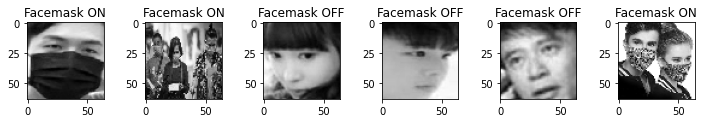

In [ ]:
SampleSize=6
fig, axs = plt.subplots(1, SampleSize, figsize=(10, 10))
plt.tight_layout()

for i in range(SampleSize):
    axs[i].imshow(x_train[i].reshape(64, 64), 'gray')
    if(y_train[i][0]==0):
        tempLabel = "Facemask ON"
    else:
        tempLabel = "Facemask OFF"
    axs[i].set_title('{}'.format(tempLabel))

# Create the model

In [ ]:
model = tf.keras.models.Sequential([
    InputLayer(input_shape=(64, 64, 1), name='input_data'),
    Conv2D(64, (3,3), activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax', name='output_logits')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

# Create a early stop, avoid overfitting





In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1)

# Training


In [ ]:
history = model.fit(x_train,y_train,validation_data=(x_test, y_test),steps_per_epoch=1000,epochs=30, verbose=1 ,callbacks=[es])

Epoch 1/30
1000/1000 [==============================] - 69s 69ms/step - loss: 0.3332 - acc: 0.8503 - val_loss: 0.2551 - val_acc: 0.8818
Epoch 2/30
1000/1000 [==============================] - 64s 64ms/step - loss: 0.1597 - acc: 0.9342 - val_loss: 0.1430 - val_acc: 0.9545
Epoch 3/30
1000/1000 [==============================] - 63s 63ms/step - loss: 0.0938 - acc: 0.9643 - val_loss: 0.1487 - val_acc: 0.9558
Epoch 00003: early stopping


# Check loss and accuracy

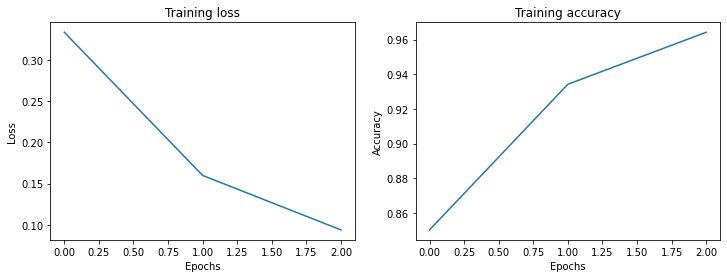

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(history.history['loss'])
axs[0].set_title('Training loss')
axs[0].set(xlabel='Epochs', ylabel='Loss')

axs[1].plot(history.history['acc'])
axs[1].set_title('Training accuracy')
axs[1].set(xlabel='Epochs', ylabel='Accuracy')
plt.show()

# Validation with test data

In [ ]:
loss, accuracy = model.evaluate(x_test,y_test)
print("Test loss: {}".format(loss))
print("Test accuracy: {}".format(accuracy))

25/25 [==============================] - 2s 92ms/step - loss: 0.1487 - acc: 0.9558
Test loss: 0.14874520897865295
Test accuracy: 0.9558441638946533


# Convert the model to Tflite model

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT] # Uncomment for optimization
tflite_quantized_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_quantized_model)

6724300

# Download the model.

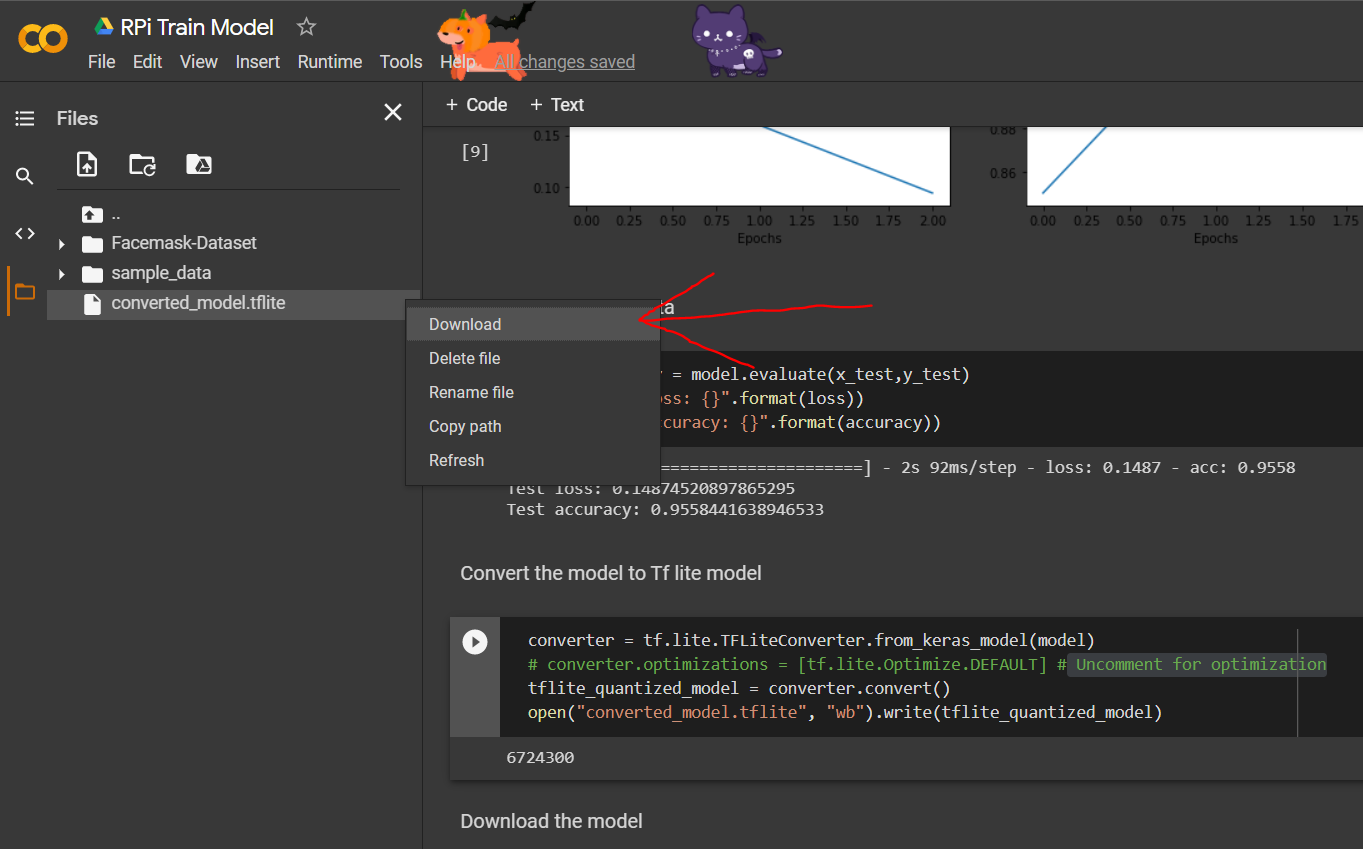